In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
import torch.nn.functional as F #relu,GD
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.models import resnet50
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np
from torchvision.transforms import RandomResizedCrop, RandomHorizontalFlip

from PIL import Image, ImageOps


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#setdevice
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    RandomResizedCrop((224, 224), scale=(0.8, 1.0)),  # Random crop and resize
    RandomHorizontalFlip(p=0.5),            # Randomly flip horizontally with 50% probability
    transforms.ToTensor(),
])

In [4]:
#Create Dataset
train_root = r"/kaggle/input/apple-disease-dataset/datasets/train"
test_root = r"/kaggle/input/apple-disease-dataset/datasets/test"

In [5]:
train_dataset = ImageFolder(train_root , transform =transform)
train_set,val_set = torch.utils.data.random_split(train_dataset,[6217,1554])
test_dataset = ImageFolder(test_root , transform =transform)
#DataLoader
train_loader = DataLoader(train_set,batch_size = 64,shuffle = True,drop_last=True)
val_loader = DataLoader(val_set, batch_size = 64,drop_last = True)
test_loader = DataLoader(test_dataset,batch_size = 64,drop_last = True)

In [6]:
train_dataset.classes

['apple_scab', 'black_rot', 'cedar_apple_rust', 'healthy']

In [7]:
len_train = len(train_set)
len_val = len(val_set)
print(len_train,len_val)
print(train_dataset.class_to_idx)

6217 1554
{'apple_scab': 0, 'black_rot': 1, 'cedar_apple_rust': 2, 'healthy': 3}


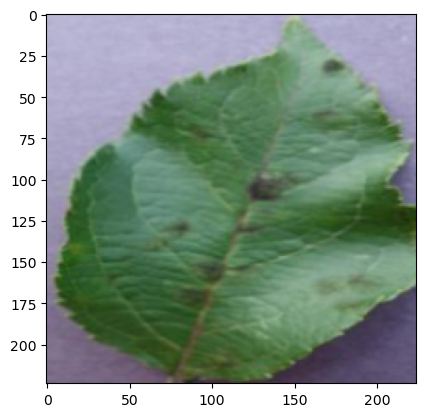

In [8]:
sample_image, _ = train_dataset[0]  
transform = transforms.ToPILImage()
sample_image = transform(sample_image)
plt.imshow(sample_image)
plt.show()

In [9]:
# pretrained model
model = resnet50(pretrained = True)
for param in model.parameters():
    param.requires_grad = False
model.fc =nn.Linear(in_features = 2048 , out_features = 4 )
model = model.to(device)
print(model)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 275MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
optimizer = optim.Adam(model.fc.parameters(),lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [11]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
epochs = 10

for epoch in range(epochs):
    total_train_loss = 0.0
    total_train_samples = 0
    total_train_correct = 0
    
    model.train()
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        scores = model(data)
        loss = criterion(scores, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        total_train_samples += data.size(0)

        # Calculate training accuracy after each batch
        _, predictions = scores.max(1)
        total_train_correct += (predictions == targets).sum().item()

    # Calculate average training loss per epoch and Accuracy
    epoch_train_loss = (total_train_loss / total_train_samples)
    train_losses.append(epoch_train_loss)
    
    epoch_train_accuracy = (total_train_correct / total_train_samples)*100
    train_accuracies.append(epoch_train_accuracy)


    # Validation Loop
    model.eval()
    num_correct = 0
    num_samples = 0
    total_val_loss = 0.0
    val_predictions = []
    val_targets = []

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device)    

            scores = model(x)
            loss = criterion(scores, y)
            total_val_loss += loss.item() 

            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum().item()
            num_samples += y.size(0)
            val_predictions.extend(predictions.cpu().numpy())
            val_targets.extend(y.cpu().numpy())

        val_acc = (float(num_correct) /float(num_samples)) * 100
        val_loss = total_val_loss / num_samples
        # Calculate average validation loss per epoch and Accuracy
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

    print(f'Epoch {epoch + 1}/{epochs} | Validation Accuracy: {val_acc:.2f} | Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_acc:.2f} | Validation Loss: {val_loss:.4f}')
# Classification report for validation data
val_report = classification_report(val_targets, val_predictions, target_names=train_dataset.classes)
print("Classification Report - Validation Data:")
print(val_report)

model.train()

Epoch 1/10 | Validation Accuracy: 91.21 | Validation Loss: 0.0128
Epoch 2/10 | Validation Accuracy: 94.92 | Validation Loss: 0.0085
Epoch 3/10 | Validation Accuracy: 96.42 | Validation Loss: 0.0062
Epoch 4/10 | Validation Accuracy: 96.09 | Validation Loss: 0.0050
Epoch 5/10 | Validation Accuracy: 96.88 | Validation Loss: 0.0042
Epoch 6/10 | Validation Accuracy: 97.27 | Validation Loss: 0.0036
Epoch 7/10 | Validation Accuracy: 97.40 | Validation Loss: 0.0032
Epoch 8/10 | Validation Accuracy: 97.79 | Validation Loss: 0.0028
Epoch 9/10 | Validation Accuracy: 97.20 | Validation Loss: 0.0027
Epoch 10/10 | Validation Accuracy: 97.98 | Validation Loss: 0.0024
Validation Accuracy: 97.98 | Validation Loss: 0.0024
Classification Report - Validation Data:
                  precision    recall  f1-score   support

      apple_scab       0.97      0.97      0.97       401
       black_rot       0.98      0.98      0.98       399
cedar_apple_rust       0.99      0.99      0.99       336
         hea

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
x.shape,y.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [13]:
print("train_losses:", train_losses)
print("val_losses:", val_losses)
print("train_accuracies:", train_accuracies)
print("val_accuracies:", val_accuracies)

train_losses: [0.01721972754205932, 0.010623866797799301, 0.007549651471187466, 0.005915753413759863, 0.004859557864976298, 0.004243120255870456, 0.0036122743712411714, 0.0032546565791150344, 0.0030381108691781454, 0.002711191733809399]
val_losses: [0.01284678012598306, 0.008471556628743807, 0.006181458321710427, 0.005038062576204538, 0.004181771432437624, 0.0035900765021021166, 0.0032350673088027784, 0.00283780277823098, 0.002744130455539562, 0.0023687503028971455]
train_accuracies: [67.33247422680412, 93.33118556701031, 94.9903350515464, 95.55412371134021, 95.95682989690721, 96.27899484536083, 97.01997422680412, 97.1971649484536, 97.2132731958763, 97.63208762886599]
val_accuracies: [91.2109375, 94.921875, 96.41927083333334, 96.09375, 96.875, 97.265625, 97.39583333333334, 97.78645833333334, 97.20052083333334, 97.98177083333334]


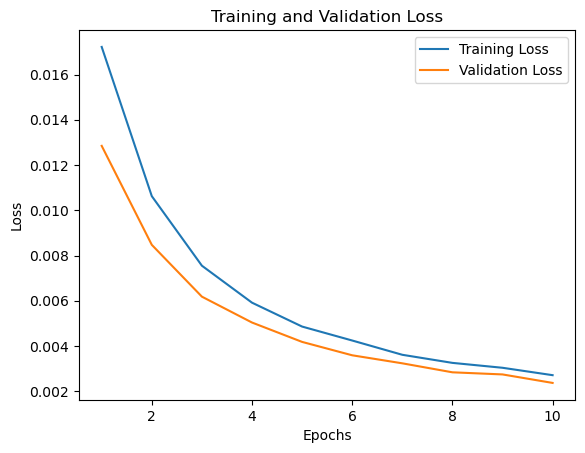

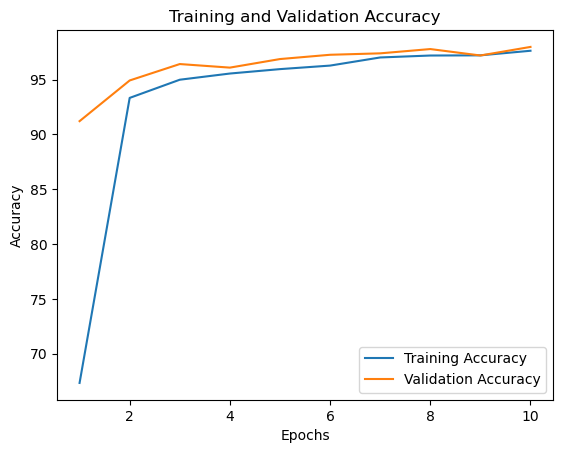

In [14]:
epochs = range(1, len(train_losses) + 1)

# Loss plot
plt.figure()
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Accuracy plot
plt.figure()
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


In [15]:
# Testing Loop
model.eval()
num_correct = 0
num_samples = 0
test_loss = 0
test_predictions = []
test_targets = []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)

        scores = model(x)
        loss = criterion(scores,y)
        test_loss += loss.item()
        _, predictions = scores.max(1)
        num_correct += (predictions == y).sum().item()
        num_samples += predictions.size(0)
        test_predictions.extend(predictions.cpu().numpy())
        test_targets.extend(y.cpu().numpy())

test_acc = (float(num_correct) / float(num_samples)) * 100
test_loss /= num_samples

print(f'Testing Accuracy: {test_acc:.2f}| Testing_loss:{test_loss:.4f}')
test_report = classification_report(test_targets, test_predictions, target_names=test_dataset.classes)
print("Classification Report - Testing Data:")
print(test_report)
model.train()


Testing Accuracy: 98.54| Testing_loss:0.0024
Classification Report - Testing Data:
                  precision    recall  f1-score   support

      apple_scab       0.98      0.98      0.98       504
       black_rot       0.99      0.99      0.99       497
cedar_apple_rust       0.98      0.99      0.99       440
         healthy       0.99      0.98      0.98       479

        accuracy                           0.99      1920
       macro avg       0.99      0.99      0.99      1920
    weighted avg       0.99      0.99      0.99      1920



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 